In [1]:
import sys
sys.path.append('..')
from utils import *
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
from tqdm import trange, tqdm
import os

# Create Dirs

In [2]:
vid_path = "../data/videoplayback.mp4"
out_dir  = "../data/clr_120_160"
image_dir = os.path.join(out_dir, 'images')
anno_dir  = os.path.join(out_dir, 'annotations')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    os.makedirs(image_dir)
    os.makedirs(anno_dir)

# Split video and process frames

In [3]:
from split_encoded_video import split_video_and_process_frames

out_w = 160
out_h = 120
to_gray = False
split_video_and_process_frames(vid_path, out_dir, out_w, out_h, to_gray)

Processed 1000 frames.
Processed 2000 frames.
Processed 3000 frames.
Processed 4000 frames.
Processed 5000 frames.
Processed 6000 frames.
Processed 7000 frames.
Processed 8000 frames.
Processed 9000 frames.
Processed 10000 frames.
Processed 11000 frames.
Processed 12000 frames.
Processed 13000 frames.
Processed 14000 frames.
Processed 15000 frames.
Processed 16000 frames.
Processed 17000 frames.
Processed 18000 frames.
Processed 19000 frames.
You Little Rippa!!!!!!!


Get a list of all the images in the `base_dir/images` directory. We also make sure each **image** has an associated **annotation**. We then just combine both train and test 

In [3]:
all_data = get_data_point_names_sequnetial(anno_dir, count=None)

  2%|▏         | 365/19796 [00:00<00:05, 3642.08it/s]

Importing images and annotations.


100%|██████████| 19796/19796 [00:03<00:00, 5249.04it/s]


In [4]:
print(all_data[0])

{'image': 'frame000000', 'throttle': 510, 'steering': 447}


# Save file of each image name in sequential order
Create a file containing every datapoint and annotation, in sequential order. This will be used for visualizing parformance once the model has been trained.

In [5]:
# import os

# data_path = "../data/all_data_sequential.txt"
# for ele in all_data:
#     n = ele['image_name']
#     s = int(ele['steering'])
#     with open(data_path, 'a') as file:
#         file.write("{}, {}\n".format(n,s))


Next, because we want to perform some stats we need to separate the annotations into their own np.array

In [6]:
annos = list()
for ele in all_data:
    annos.append(ele["steering"])

Next we run do some stats to see if we have any biases in the data

mean: 487.3090523338048
median: 449.0
mode: ModeResult(mode=array([1021]), count=array([1394]))
var: 68200.89680833611
std: 261.1530141666684


[-10, 1024, 0, 200]

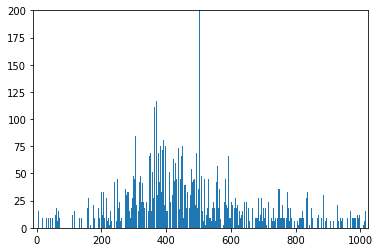

In [7]:
print("mean: {}".format(np.mean(annos)))
print("median: {}".format(np.median(annos)))
print("mode: {}".format(stats.mode(annos)))
print("var: {}".format(np.var(annos)))
print("std: {}".format(np.std(annos)))
plt.hist(annos, 1024)
plt.axis([-10, 1024, 0, 200])

If there is a definate bias in your data then we'll need to even it out. The code below compiles a dictionary with each key being a steering value (eg: 0-1023) and the value being a list of the corriponding image name. We will use this to select up to `max_count` number of images associated with a given value.

```
# eg:
evened_annos = {200: [frame01, frame20, frame04], 
                201: [frame03, frame07]...so on}
```

In [9]:
_annos = {}
for ele in all_data:
    i = ele['image']
    s = ele['steering']
    if int(s) not in _annos.keys():
        _annos[int(s)] = [i,]
    else:
        _annos[int(s)].append(i)

Here we only select `max_count` from each `key`

In [10]:
max_count = 20
for key in _annos.keys():
    np.random.shuffle(_annos[key])
    if len(_annos[key]) > max_count:
        _annos[key] = _annos[key][:max_count]

Now we re-run our stats

In [24]:
image_names = []
for ele in _annos.keys():
    for image in _annos[ele]:
        image_names.append(image)

evened_annos = []
for name in image_names:
    evened_annos.append(load_anno(os.path.join(anno_dir, f"{name}.json")))
# for s in evened_annos.keys():
#     print(evened_annos[s])
#     for i in evened_annos[s]:
#         steer.append(s)
#         images.append(i)
#         throt.append(t)


count: 10170
mean: 500.39567354965584
median: 478.0
mode: ModeResult(mode=array([3]), count=array([20]))
var: 57039.67530084917
std: 238.82980404641538


[-10, 1024, 0, 60]

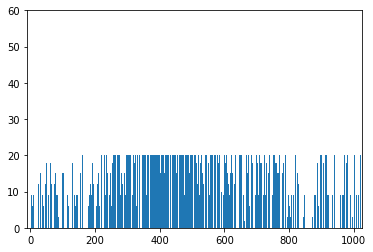

In [26]:
test = list()
for ele in evened_annos:
    test.append(ele["steering"])
print("count: {}".format(len(test)))
print("mean: {}".format(np.mean(test)))
print("median: {}".format(np.median(test)))
print("mode: {}".format(stats.mode(test)))
print("var: {}".format(np.var(test)))
print("std: {}".format(np.std(test)))
plt.hist(test, 1024)
plt.axis([-10, 1024, 0, 60])

Finally we shuffle the data, split into training and test sets then write to file

In [34]:
import os

training_frac = 0.8
rand_idxs = np.array(list(range(len(evened_annos))))
np.random.shuffle(rand_idxs)
train = {"data" : []}
test  = {"data" : []}
train_path = "../data/evened_train.txt"
test_path = "../data/evened_test.txt"

assert not os.path.exists(train_path), "train_path exists, you'll need to delete it before trying again."
assert not os.path.exists(test_path),  "test_path exists, you'll need to delete it before trying again."


for idx in rand_idxs:
    path = train_path
    if np.random.rand() > training_frac:
        path = test_path
    with open(path, 'a') as f:
        image_name = evened_annos[idx]["image"] 
        f.write(f"{image_name}\n")